# Natural Language Processing
# Irzan Fajari Nurahmadan

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import plotly.graph_objects as go

%matplotlib inline

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Import Dataset
The dataset was obtained from Kaggle under the title Amazon Fine Food Reviews

In [ ]:
df = pd.read_csv('/content/drive/My Drive/dataset/Reviews.csv')

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.shape

(568454, 10)

# Data Preprocessing

In [ ]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df['Text'] = df['Text'] + ' ' + df['Summary']

In [ ]:
df = df.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary'],axis=1)

In [ ]:
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [ ]:
df = df[df["Score"]!=3]

In [ ]:
df["Score"] = df["Score"].apply(lambda x : 1 if x>3 else 0)

In [ ]:
class_dist = df['Score'].value_counts()

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

ditribution_plot(x= class_dist.index, y= class_dist.values, name= 'Class Distribution')

In [ ]:
#dikarenakan data yang terlalu besar dan class distribution yang tidak seimbang maka kita harus mengurangi total data menjadi 5000 setiap kelasnya agar pemodelan berlangsung dengan cepat
df_zero = df[df['Score'] == 0].head(5000)
df_one = df[df['Score'] == 1].head(5000)
df = pd.concat([df_zero,df_one],axis=0)

In [ ]:
class_dist = df['Score'].value_counts()
ditribution_plot(x= class_dist.index, y= class_dist.values, name= 'Class Distribution')

# Text Preprocessing

In [ ]:
# remove punctuation and numbers in string
def clean(text) :
  for separator in string.punctuation:
    text = text.replace(separator,' ')
  
  words = []
  for word in text.split():
    word = word.strip()
    result_word = ''.join(i for i in word if not i.isdigit())
    words.append(result_word)
  
  return ' '.join(words)

df['Text'] = df['Text'].apply(lambda x: clean(x))

In [ ]:
stop_words = set(stopwords.words('english'))
df['Text'] = df['Text'].apply(lambda x :  [w.lower() for w in word_tokenize(x) if not w.lower() in stop_words])

In [ ]:
# back to normal string
df['Text'] = df['Text'].apply(lambda x :  ' '.join(x))

In [ ]:
X = df['Text'].values
y = df['Score'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

# Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=20000, oov_token='x')
tokenizer.fit_on_texts(X_train) 
tokenizer.fit_on_texts(X_test)

sekuens_latih = tokenizer.texts_to_sequences(X_train)
sekuens_test = tokenizer.texts_to_sequences(X_test)

padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

# Make LSTM Based Model

In [ ]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=16),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Callback To Control Train

In [ ]:
Callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

# Train LSTM Model

In [ ]:
history = model.fit(padded_latih, y_train, epochs=32, 
                    validation_data=(padded_test, y_test),callbacks=Callback)

Epoch 1/32
250/250 [==============================] - 10s 35ms/step - loss: 0.4692 - accuracy: 0.7731 - val_loss: 0.2839 - val_accuracy: 0.8805
Epoch 2/32
250/250 [==============================] - 8s 32ms/step - loss: 0.1893 - accuracy: 0.9264 - val_loss: 0.2477 - val_accuracy: 0.9030
Epoch 3/32
250/250 [==============================] - 8s 32ms/step - loss: 0.0925 - accuracy: 0.9715 - val_loss: 0.2737 - val_accuracy: 0.9030
Epoch 4/32
250/250 [==============================] - 8s 32ms/step - loss: 0.0435 - accuracy: 0.9886 - val_loss: 0.3555 - val_accuracy: 0.8980
Epoch 5/32
250/250 [==============================] - 8s 32ms/step - loss: 0.0198 - accuracy: 0.9952 - val_loss: 0.4171 - val_accuracy: 0.8960


# Visualize the Training History of Model

In [ ]:
def graph(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

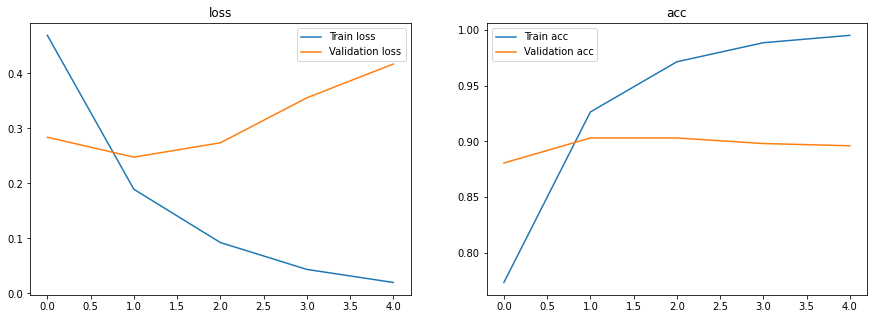

In [ ]:
graph(history)